In [1]:
import pandas as pd

import gensim

import gensim.corpora as corpora
from gensim import corpora, models
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models

from tqdm import tqdm

In [2]:
# Read Data
# Select part to show, because the dataset is too large and cost to much time to have the result
# Will upload result from whole dataset later
during = pd.read_csv('D:/Python/GA/during_comments_clean.csv')
post = pd.read_csv('D:/Python/GA/post_comments_clean.csv')
pre = pd.read_csv('D:/Python/GA/pre_comments_clean.csv')

In [3]:
print(during.body[0])
print(type(during.body[0]))

['jim', 'nantz', 'tomo', 'romo', 'mvps', 'game', 'happy', 'nbc', 'broadcasting']
<class 'str'>


In [4]:
during

,Unnamed: 0,author_fullname,body,created_utc,distinguished,id,is_submitter,link_id,parent_id,score
0,0,t2_1aq6fjov,"['jim', 'nantz', 'tomo', 'romo', 'mvps', 'game...",2021-02-08 00:00:00,NaN,gmixl8h,False,t3_ld4v32,t3_ld4v32,1
1,1,NaN,['remove'],2021-02-08 00:00:00,NaN,gmixl8b,False,t3_lew1td,t3_lew1td,1
2,2,t2_2io0vlq4,"['agree', 'get', '...', 'sure', 'cheer', 'wish...",2021-02-07 23:59:59,NaN,gmixl6x,False,t3_lcweqk,t1_gmisn4g,1
3,3,t2_v36ui,"['surprised', 'see', 'massive', 'attention', '...",2021-02-07 23:59:59,NaN,gmixl6r,False,t3_leyrrr,t1_gmix767,1
4,4,t2_6zbzxms0,"['haha', 'get', 'eem', 'really', 'scsred']",2021-02-07 23:59:57,NaN,gmixl2j,False,t3_lez0fz,t1_gmixcr5,1
...,...,...,...,...,...,...,...,...,...,...
6401099,6401099,t2_bsr9b,"['get', 'deserve', '🧻🤚']",2021-01-27 14:56:34,NaN,gkyc6ie,False,t3_l65p3u,t1_gkybumm,1
6401100,6401100,t2_dq57x,"['fuck', 'fund', 'announces', 'cover', 'jezzus...",2021-01-27 14:56:34,NaN,gkyc6id,False,t3_l65p3u,t3_l65p3u,1
6401101,6401101,NaN,['remove'],2021-01-27 14:56:34,NaN,gkyc6i9,False,t3_l6636a,t3_l6636a,1
6401102,6401102,t2_3fjtg4w,"['25', 'call', '25', 'friday']",2021-01-27 14:56:34,NaN,gkyc6i5,False,t3_l65z4v,t3_l65z4v,1


In [5]:
# There are a lot of ['Remove'] in dataset. 
# They are posts that content has been deleted, so we remove them here.
def remove(dataframe, feature = 'body'):
    tqdm.pandas(desc = 'Progress: ')
    dataframe[feature] = dataframe[feature].progress_apply(lambda x: x.strip("[]',"))
    dataframe[feature] = dataframe[feature].progress_apply(lambda x: x.split("', '"))

    
    bl1 = []
    for x in dataframe[feature]:
        bl1.append(('remove' in x) & (x[0] == 'remove'))
    bl1 = pd.Series(bl1)   
    df = dataframe[bl1 == False]
    
    df.reset_index(inplace=True)
    df.drop(['index', 'Unnamed: 0'], axis=1, inplace = True)
    
    lis= []
    for x in tqdm(df[feature], desc = 'Progress: '):
        if 'delete' in x:
            lis.append(1)
        else:
            lis.append(0)
    lis = pd.Series(lis)
    df = df[lis == 0]
    
    df.reset_index(inplace=True)
    df.drop(['index'], axis=1, inplace = True)
    
    return df

In [6]:
# Apply to three stages
during = remove(during)
post = remove(post)
pre = remove(pre)

Progress: 100%|██████████| 6401104/6401104 [00:13<00:00, 468128.96it/s] 
C:\Users\Administrator\AppData\Local\Temp\ipykernel_21676\1396846449.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['index', 'Unnamed: 0'], axis=1, inplace = True)
Progress: 100%|██████████| 4097203/4097203 [00:01<00:00, 3535120.04it/s]
C:\Users\Administrator\AppData\Local\Temp\ipykernel_21676\1396846449.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['index'], axis=1, inplace = True)
Progress: 100%|██████████| 2680006/2680006 [00:07<00:00, 345354.46it/s]
C:\Users\Administrator\AppData\Local\Temp\ipykernel_21676\139684

In [7]:
post.body[1][1] == 'remove'

False

LDA algorithm is an unsupervised learning algorithm that works on a probabilistic statistical model to discover topics that the document contains automatically.
This algorithm works on certain assumptions. The assumption is that the document was generated by picking a set of topics and picking a set of words for each topic. In other words, we can say that the document is a probability distribution over the latent topics, and topics are probability distribution over the words.

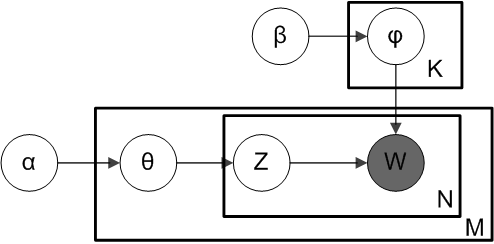

Here, 
α
 and 
β
 are two hyperparameters that we have to initialise manually, and they symbolize per topic distribution(
α
) and per topic word distribution(
β
), respectively. And Z is the topic for the N-th word in document M, and W is the specific word. We can only see W(specific words) in the documents because it is only an observable variable, and all others are latent.

θ
 is the matrix where rows are the documents; columns are topics, and 
θ
(
i
,
j
)
 represents the probability of 
i
t
h
 document containing 
j
t
h
 topic. Similarly, 
ϕ
 is the matrix where rows are the topics; columns are words, and 
ϕ
(
i
,
j
)
 represents the probability of 
i
t
h
 topic containing 
j
t
h
 word. According to the distribution of 
ϕ
; K individual words are generated for the topics.

With the help of this LDA, try to estimate the words that belong to each topic and find the topics in documents accordingly.

#tokenize articles

In [8]:
during

,author_fullname,body,created_utc,distinguished,id,is_submitter,link_id,parent_id,score
0,t2_1aq6fjov,"[jim, nantz, tomo, romo, mvps, game, happy, nb...",2021-02-08 00:00:00,NaN,gmixl8h,False,t3_ld4v32,t3_ld4v32,1
1,t2_2io0vlq4,"[agree, get, ..., sure, cheer, wish, well]",2021-02-07 23:59:59,NaN,gmixl6x,False,t3_lcweqk,t1_gmisn4g,1
2,t2_v36ui,"[surprised, see, massive, attention, amc, rece...",2021-02-07 23:59:59,NaN,gmixl6r,False,t3_leyrrr,t1_gmix767,1
3,t2_6zbzxms0,"[haha, get, eem, really, scsred]",2021-02-07 23:59:57,NaN,gmixl2j,False,t3_lez0fz,t1_gmixcr5,1
4,t2_8srqliic,"[call, look, better]",2021-02-07 23:59:57,NaN,gmixl25,False,t3_levf1j,t1_gmix508,1
...,...,...,...,...,...,...,...,...,...
3893220,t2_2b9x3kng,"[stop, selling, amc, glass, lickers]",2021-01-27 14:56:34,NaN,gkyc6ik,False,t3_l6261q,t3_l6261q,1
3893221,t2_17234i,"[happens, halt]",2021-01-27 14:56:34,NaN,gkyc6ih,False,t3_l6261q,t1_gkybxsz,1
3893222,t2_bsr9b,"[get, deserve, 🧻🤚]",2021-01-27 14:56:34,NaN,gkyc6ie,False,t3_l65p3u,t1_gkybumm,1
3893223,t2_dq57x,"[fuck, fund, announces, cover, jezzus, fall, c...",2021-01-27 14:56:34,NaN,gkyc6id,False,t3_l65p3u,t3_l65p3u,1


In [9]:
post

,author_fullname,body,created_utc,distinguished,id,is_submitter,link_id,parent_id,score
0,t2_aikpi,"[🚢, 🌙]",2021-02-09 04:59:58,NaN,gmo07vb,False,t3_lflpoz,t1_gmnylp2,1
1,t2_bn79u8d,"[say, sell, realize, loss, tax, credit, buy, g...",2021-02-09 04:59:56,NaN,gmo07s8,False,t3_lflzy4,t1_gmn8lgw,1
2,t2_4d4r9iby,"[spy, 390p, 2/10, spy, 392p, 2/10, spy, 398p, ...",2021-02-09 04:59:55,NaN,gmo07px,False,t3_lflpoz,t3_lflpoz,3
3,t2_6fb5ka0x,"[lol, melvin, bot, factory]",2021-02-09 04:59:54,NaN,gmo07ox,False,t3_lf9hv1,t1_gmnrb2s,1
4,t2_gmtwa,"[put, fell, burn, ring, 🔥, go, 🔥, go, high, bu...",2021-02-09 04:59:49,NaN,gmo07ee,False,t3_lflpoz,t3_lflpoz,6
...,...,...,...,...,...,...,...,...,...
2177595,t2_hebx3,[definitely],2021-02-09 05:00:07,NaN,gmo08f5,False,t3_lf9rdy,t1_gmo03rq,1
2177596,t2_170k9avo,"[market, rotation, portfolio, mm]",2021-02-09 05:00:06,NaN,gmo08cg,False,t3_lflpoz,t3_lflpoz,1
2177597,t2_16yg32,"[want, gamble, bit, check, vaxil, bio, news, c...",2021-02-09 05:00:05,NaN,gmo08ai,False,t3_lfgwjy,t1_gmloaa4,1
2177598,t2_2ai16a90,"[12, find, tomorrow, short]",2021-02-09 05:00:03,NaN,gmo086b,False,t3_lflpoz,t1_gmnokpg,1


In [10]:
dictionary = corpora.Dictionary(during.body)
#dataset = [d.split() for d in dataset]

corpus = [dictionary.doc2bow(x) for x in during.body]

In [11]:
lda = models.ldamodel.LdaModel(corpus = corpus
                               , id2word = dictionary
                               , num_topics = 10
                               , random_state = 123
                               , update_every = 1
                               #, chunksize = 100
                               #, passes = 10
                               #, alpha = 'symmetric'
                               #, per_word_topics = True
                               , eta = 0.05
                              )

In [12]:
lda.print_topics(num_words=5
                )

[(0,
  '0.079*"amp" + 0.063*"yolo" + 0.060*"flair" + 0.060*"please" + 0.054*"bot"'),
 (1, '0.131*"buy" + 0.065*"sell" + 0.051*"share" + 0.047*"dip" + 0.027*"gme"'),
 (2, '0.142*"nok" + 0.121*"amc" + 0.096*"hold" + 0.083*"gme" + 0.070*"u"'),
 (3,
  '0.169*"like" + 0.121*"stock" + 0.053*"halt" + 0.037*"look" + 0.028*"meme"'),
 (4, '0.103*"fuck" + 0.037*"get" + 0.032*"shit" + 0.031*"ban" + 0.027*"stop"'),
 (5,
  '0.082*"short" + 0.029*"squeeze" + 0.027*"melvin" + 0.025*"market" + 0.024*"fund"'),
 (6,
  '0.049*"day" + 0.039*"today" + 0.033*"line" + 0.029*"still" + 0.028*"cnbc"'),
 (7, '0.153*"🚀" + 0.048*"yes" + 0.031*"come" + 0.031*"🚀🚀🚀🚀" + 0.029*"rocket"'),
 (8,
  '0.065*"retard" + 0.046*"hold" + 0.042*"lol" + 0.037*"hand" + 0.033*"fuck"'),
 (9,
  '0.030*"make" + 0.026*"go" + 0.026*"money" + 0.021*"get" + 0.020*"think"')]

In [13]:
# During
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda, corpus, dictionary)

D:\Anaconda\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.126014  0.170671       1        1  21.845329
1      0.196682 -0.117023       2        1  14.509952
5     -0.023000  0.238376       3        1  11.032006
4      0.104453  0.135868       4        1  10.017234
0     -0.282050 -0.126976       5        1   9.673834
2      0.180986 -0.294859       6        1   7.696123
6      0.034584  0.085532       7        1   7.481776
8      0.117917 -0.060748       8        1   6.975453
3     -0.262910 -0.122660       9        1   5.866541
7     -0.192676  0.091819      10        1   4.901751, topic_info=      Term           Freq          Total Category  logprob  loglift
89     buy  840203.000000  840203.000000  Default  30.0000  30.0000
83    like  377598.000000  377598.000000  Default  29.0000  29.0000
1992   nok  415828.000000  415828.000000  Default  28.0000  28.0000
17     amc  354250.000000  354250.000000  Default  27.0000  27.0000
1708     🚀  286665.000000  286665.000000  Default  26.0000  26.0000
...    ...            ...            ...      ...      ...      ...
25     see   38732.326264  164969.790646  Topic10  -3.8762   1.5665
675     dd   13530.273964   19044.867930  Topic10  -4.9280   2.6737
1     game   14606.889271   40276.392947  Topic10  -4.8514   2.0013
264   need   16420.163673  116182.178873  Topic10  -4.7344   1.0589
242   real   13586.901429   40950.546458  Topic10  -4.9238   1.9123

[472 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1231      8  0.999983          
1334      5  0.999976        --
9         1  0.000622       ...
9         2  0.170157       ...
9         3  0.052895       ...
...     ...       ...       ...
1792      4  0.999992       🚀🚀🚀
1742     10  0.999985      🚀🚀🚀🚀
3983      3  0.999990     🚀🚀🚀🚀🚀
3508      7  0.999930   🚀🚀🚀🚀🚀🚀🚀
2039      3  0.999963  🚀🚀🚀🚀🚀🚀🚀🚀

[634 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 2, 6, 5, 1, 3, 7, 9, 4, 8])

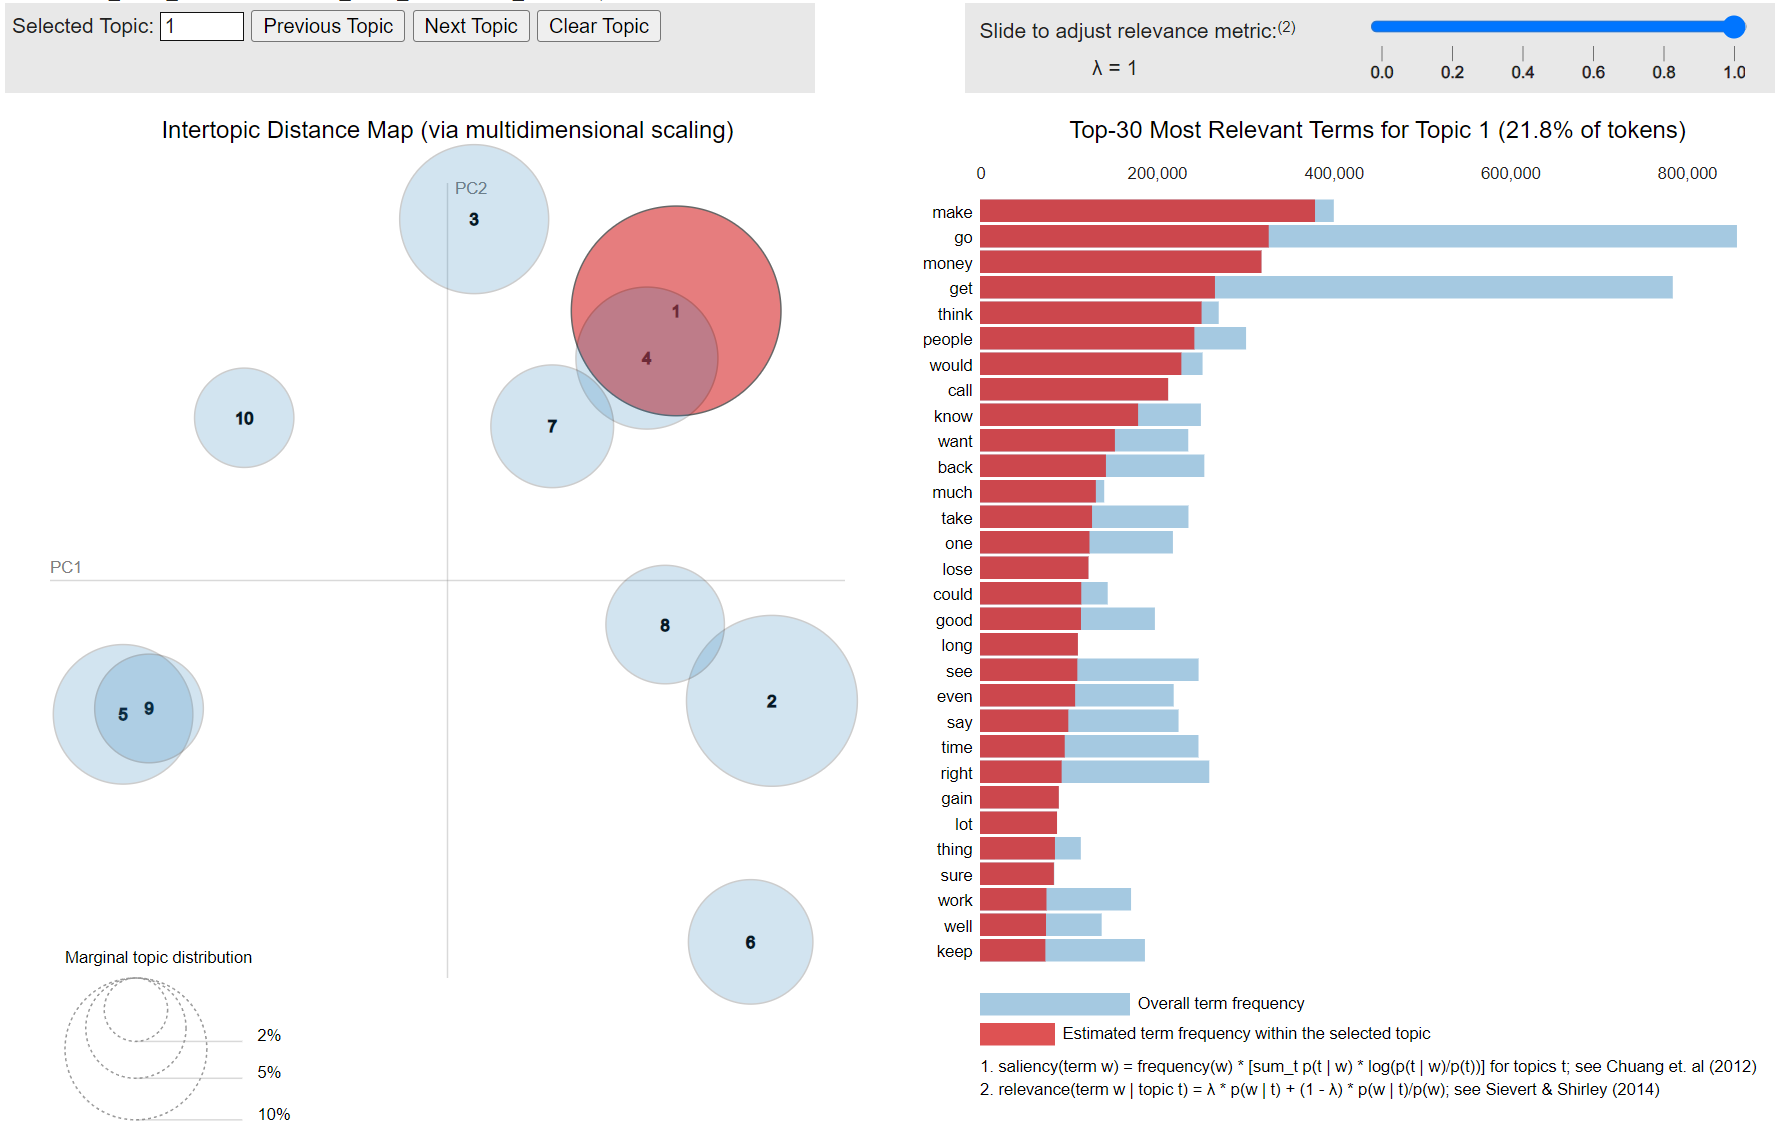

In [14]:
# post

post_dictionary = corpora.Dictionary(post.body)

post_corpus = [post_dictionary.doc2bow(x) for x in post.body]

post_lda = models.ldamodel.LdaModel(corpus = post_corpus
                               , id2word = post_dictionary
                               , num_topics = 10
                               , random_state = 123
                               , update_every = 1
                               #, chunksize = 100
                               #, passes = 10
                               #, alpha = 'symmetric'
                               #, per_word_topics = True
                               , eta = 0.05
                              )

lda.print_topics(num_words=5
                )

pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(post_lda, post_corpus, post_dictionary)

D:\Anaconda\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.190964  0.102822       1        1  23.074872
1     -0.187712  0.051139       2        1  12.927758
2     -0.195706 -0.053055       3        1  11.743824
3     -0.062136  0.003431       4        1   9.565234
6     -0.126171 -0.177082       5        1   8.635409
0      0.139658  0.238223       6        1   7.541194
8      0.328718 -0.077175       7        1   7.419530
4      0.084746  0.259128       8        1   7.193914
5      0.017261 -0.192375       9        1   6.612083
7      0.192307 -0.155057      10        1   5.286180, topic_info=        Term           Freq          Total Category  logprob  loglift
5        gme  175374.000000  175374.000000  Default  30.0000  30.0000
166     like  193444.000000  193444.000000  Default  29.0000  29.0000
6       hold  158606.000000  158606.000000  Default  28.0000  28.0000
3        buy  201091.000000  201091.000000  Default  27.0000  27.0000
27        go  301727.000000  301727.000000  Default  26.0000  26.0000
...      ...            ...            ...      ...      ...      ...
99      yeah   25013.178713   42525.901482  Topic10  -3.7195   2.4094
1035   wrong   14781.482551   22819.835052  Topic10  -4.2455   2.5058
51       day   20927.048556   96914.809645  Topic10  -3.8979   1.4073
1405   guess    9646.192560   18192.215180  Topic10  -4.6723   2.3056
2257  follow    9130.748242   13066.694196  Topic10  -4.7272   2.5817

[489 rows x 6 columns], token_table=      Topic      Freq Term
term                      
399       4  0.999967     
564       3  0.285265   ..
564       4  0.714717   ..
172       1  0.226606  ...
172       2  0.070236  ...
...     ...       ...  ...
398       9  0.998185    ’
100       2  0.999989    “
101       2  0.999977    ”
155       5  0.999932    😂
443       3  0.999959    🚀

[660 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 2, 3, 4, 7, 1, 9, 5, 6, 8])

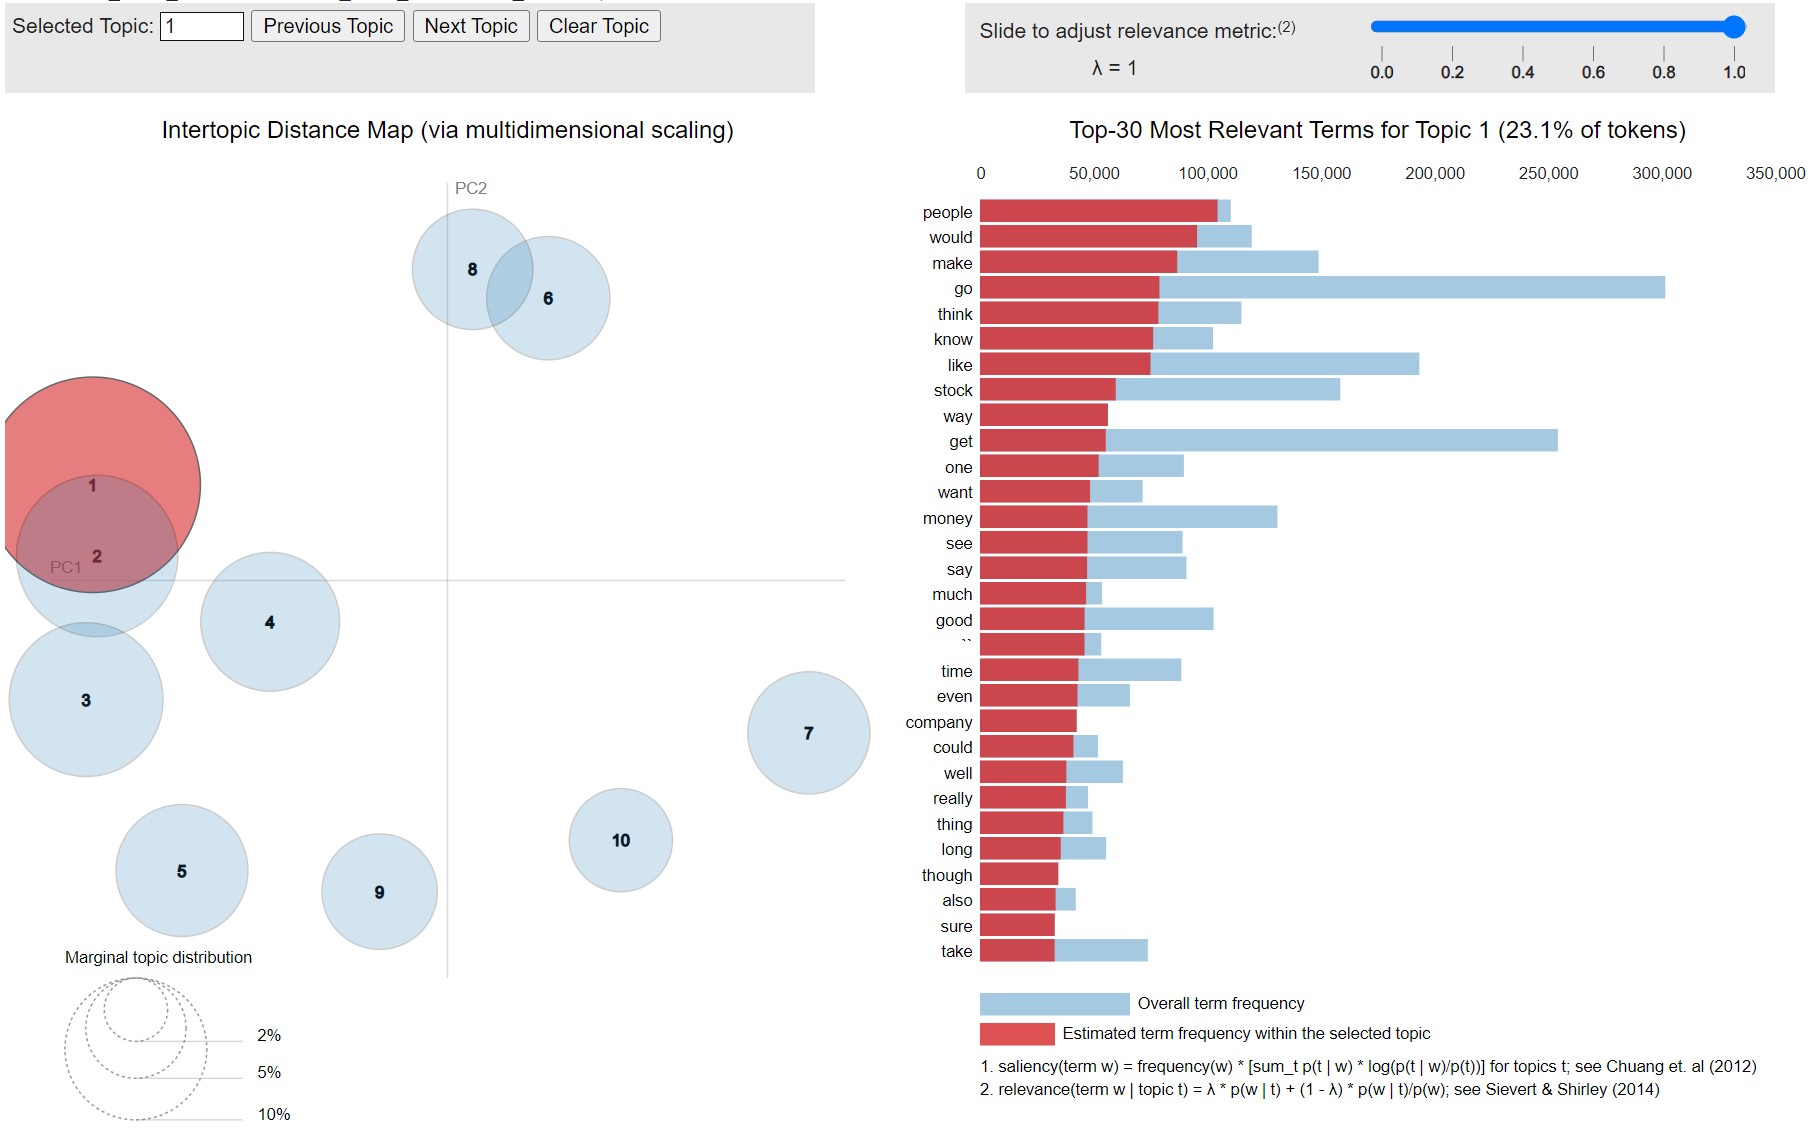

In [25]:
# pre

pre_dictionary = corpora.Dictionary(pre.body)

pre_corpus = [pre_dictionary.doc2bow(x) for x in pre.body]

pre_lda = models.ldamodel.LdaModel(corpus = pre_corpus
                               , id2word = pre_dictionary
                               , num_topics = 10
                               , random_state = 123
                               , update_every = 1
                               #, chunksize = 100
                               #, passes = 10
                               #, alpha = 'symmetric'
                               #, per_word_topics = True
                               , eta = 0.05
                              )

pre_lda.print_topics(num_words=5
                )

pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(pre_lda, pre_corpus, pre_dictionary)

D:\Anaconda\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.196954 -0.046877       1        1  22.440558
8     -0.114491 -0.087329       2        1  11.981557
9     -0.114895 -0.025052       3        1  11.729312
3     -0.173469 -0.035934       4        1  11.193161
7     -0.148509  0.005995       5        1   9.745205
4     -0.090319  0.062677       6        1   9.137716
0      0.026511  0.071021       7        1   7.716091
1      0.300974 -0.189615       8        1   6.379883
5      0.202428  0.397736       9        1   5.301939
2      0.308724 -0.152622      10        1   4.374578, topic_info=          Term           Freq          Total Category  logprob  loglift
74         buy  181200.000000  181200.000000  Default  30.0000  30.0000
2929        --   98162.000000   98162.000000  Default  29.0000  29.0000
190       http  100789.000000  100789.000000  Default  28.0000  28.0000
6         fuck  113034.000000  113034.000000  Default  27.0000  27.0000
174        amp   88836.000000   88836.000000  Default  26.0000  26.0000
...        ...            ...            ...      ...      ...      ...
359   question   10815.005452   17010.996495  Topic10  -4.0285   2.6764
138     either    8445.752610   12901.189346  Topic10  -4.2758   2.7057
566         dd    9142.354704   15530.057467  Topic10  -4.1965   2.5995
508       tell   11097.817489   24986.546745  Topic10  -4.0027   2.3178
193      learn    4968.197742    9610.259465  Topic10  -4.8064   2.4696

[492 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
848       5  0.999979      
2929      9  0.999996    --
2931      8  0.999913    -|
257       4  0.000144   ...
257       5  0.999776   ...
...     ...       ...   ...
108       4  0.999911     😂
68        7  0.999985     🚀
322       9  0.999972   🚀🚀🚀
881       9  0.999807  🚀🚀🚀🚀
2993      5  0.999821     🤡

[700 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 9, 10, 4, 8, 5, 1, 2, 6, 3])

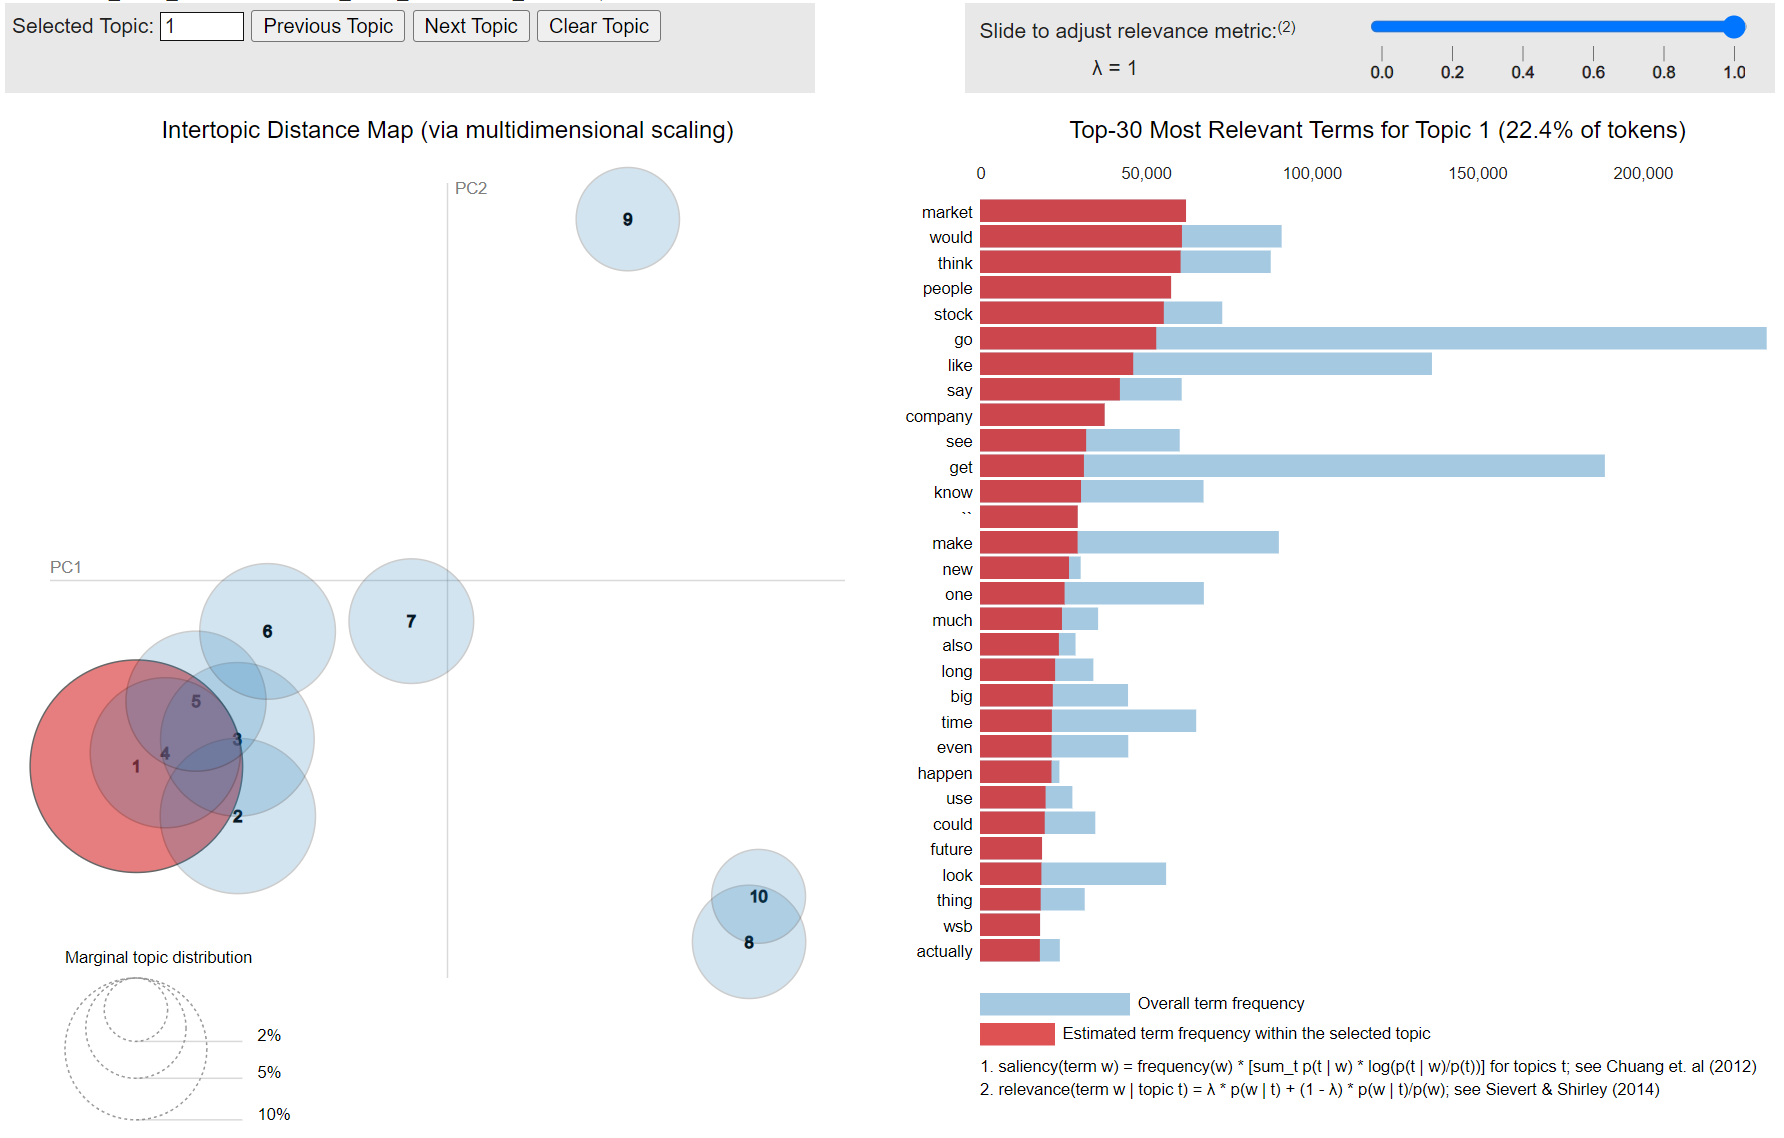